# Classifier using LSTM layers

## 1. Importing Libraries

In [101]:
import tensorflow as tf
import numpy as np

data_folder = '../data/quickdraw'

EPOCHS = 10
BATCH_SIZE = 32

MAX_SEQ_LENGTH = 95

## 2. Data Preprocessing

### 2.1. Loading the data

In [102]:
import os


def get_categories_from_data(folder, n=None):
    categories = []
    files = os.listdir(folder)

    for file in files:
        fname = file[16:-7]
        if len(fname) > 0:
            categories.append(fname)

    if n is None:
        return categories
    
    return categories[:n]

classes = get_categories_from_data(data_folder)
class_id = dict(zip(classes, range(len(classes))))


camera_data = np.load(f'../data/sketchrnn/sketchrnn_camera.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/sketchrnn/sketchrnn_cell_phone.npz', allow_pickle=True, encoding='latin1')

class_id

{'camera': 0, 'cell phone': 1}

In [103]:
def interpolate_strokes(strokes, target_length):
    """Interpolate a sequence of strokes to the target length."""
    current_length = len(strokes)
    if current_length == target_length:
        return strokes
    
    interpolated_strokes = np.zeros((target_length, 3), dtype=np.float32)
    interp_indices = np.floor(np.linspace(0, current_length-1, num=target_length)).astype(int)
    
    for i, idx in enumerate(interp_indices):
        interpolated_strokes[i] = strokes[idx]
    
    for i in range(target_length - 1):
        if interp_indices[i] != interp_indices[i + 1]:
            interpolated_strokes[i, 2] = strokes[interp_indices[i], 2]
        else:
            interpolated_strokes[i, 2] = 0
    
    # Ensure the last pen_state remains as the original last one
    interpolated_strokes[-1, 2] = strokes[-1, 2]
    
    return interpolated_strokes

def resize_and_normalize_drawings(data, size):
    """Resize and normalize drawing datasets."""
    resized_data = []
    for drawing in data['train']:
        resized_drawing = interpolate_strokes(drawing, size)
        resized_data.append(resized_drawing)
    return np.array(resized_data)

resized_camera_drawings = resize_and_normalize_drawings(camera_data, size=MAX_SEQ_LENGTH)
resized_cellphone_drawings = resize_and_normalize_drawings(cellphone_data, size=MAX_SEQ_LENGTH)

resized_camera_drawings.shape, resized_cellphone_drawings.shape

((70000, 95, 3), (70000, 95, 3))

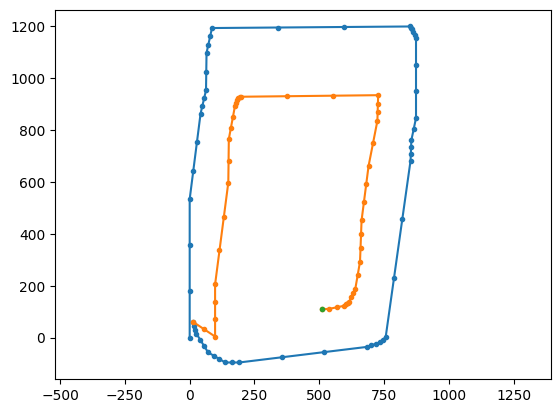

In [104]:
from matplotlib import pyplot as plt


def draw_strokes(data):
    """
    Draw stroke data from an array of (dx, dy, pen_state).

    Args:
    data (np.array): Stroke data array of shape (n, 3) where each row is (dx, dy, pen_state)
    """
    # Initialize a plot
    fig, ax = plt.subplots()
    
    # Starting point
    x, y = 0, 0
    points_x = [x]
    points_y = [y]

    # Iterate over the stroke data
    for dx, dy, pen_state in data:
        # Update position
        x += dx
        y += dy
        points_x.append(x)
        points_y.append(y)

        # If pen_state is 1, plot the current segment and start a new one
        if pen_state == 1:
            ax.plot(points_x, points_y, marker='.')
            points_x = [x]
            points_y = [y]

    # Plot the last segment
    ax.plot(points_x, points_y, marker='.')

    ax.axis('equal')
    plt.show()
    
draw_strokes(resized_cellphone_drawings[0])

In [105]:
from sklearn.model_selection import train_test_split

def prepare_train_test_datasets(camera_drawings, cellphone_drawings, test_size=0.2):
    """
    Prepare training and testing datasets from the resized drawing data of cameras and cellphones.
    
    Args:
    camera_drawings (np.array): Resized drawings of cameras.
    cellphone_drawings (np.array): Resized drawings of cellphones.
    test_size (float): The proportion of the dataset to include in the test split.
    
    Returns:
    tuple: Train and test datasets containing features and labels.
    """
    # Labels for the datasets
    camera_labels = np.zeros(camera_drawings.shape[0])
    cellphone_labels = np.ones(cellphone_drawings.shape[0])
    
    # Combine the drawings from both categories
    combined_drawings = np.concatenate([camera_drawings, cellphone_drawings], axis=0)
    combined_labels = np.concatenate([camera_labels, cellphone_labels], axis=0)
    
    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(
        combined_drawings, combined_labels, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_train_test_datasets(resized_camera_drawings, resized_cellphone_drawings, test_size=0.2)

In [106]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((112000, 95, 3), (112000,), (28000, 95, 3), (28000,))

In [107]:
def convert_to_tensor_datasets(X_train, X_test, y_train, y_test, batch_size=32):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.
    
    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    # Convert numpy arrays to TensorFlow tensors
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    
    # Shuffle and batch the datasets
    train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
    
    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train, X_test, y_train, y_test, batch_size=BATCH_SIZE)

In [108]:
print(len(train_dataset))
print(len(test_dataset))

3500
875


## 3. Model Building

### 3.2. Classic Neural Network

In [109]:
class ClassicNN:
    def __init__(self, input_shape, num_categories, n_qubits=5, lr=0.001, fname=None):
        self.state_shape = input_shape
        self.num_categories = num_categories
        
        self.n_qubits = n_qubits
        self.learning_rate = lr
        self.model = self.create_model()
        
        if fname:
            self.model.load_weights(fname)

    def create_model(self):
        model = tf.keras.models.Sequential()
        
        # Input layer
        model.add(tf.keras.layers.InputLayer(input_shape=self.state_shape))
        
        # Masking layer for pre-processing
        model.add(tf.keras.layers.Masking(mask_value=0.))
        
        # Convolutional layers
        model.add(tf.keras.layers.Conv1D(16, kernel_size=4, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv1D(32, kernel_size=5, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPool1D(pool_size=2))
        
        model.add(tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPool1D(pool_size=2))
        
        # LSTM layers
        model.add(tf.keras.layers.LSTM(128, return_sequences=True))
        model.add(tf.keras.layers.LSTM(128))
        
        # Dense layers
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        
        # Output layer
        model.add(tf.keras.layers.Dense(self.num_categories, activation='softmax'))
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
        return model
    
    def predict(self, x):
        return self.model.predict(x, verbose=0)[0]

In [110]:
input_shape = (95, 3)
nn = ClassicNN(input_shape, 2)

model = nn.create_model()
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_23 (Masking)        (None, 95, 3)             0         
                                                                 
 conv1d_92 (Conv1D)          (None, 92, 16)            208       
                                                                 
 batch_normalization_92 (Bat  (None, 92, 16)           64        
 chNormalization)                                                
                                                                 
 conv1d_93 (Conv1D)          (None, 88, 32)            2592      
                                                                 
 batch_normalization_93 (Bat  (None, 88, 32)           128       
 chNormalization)                                                
                                                                 
 conv1d_94 (Conv1D)          (None, 86, 64)          

## 4. Training the Model

In [111]:
checkpoint_filepath = 'models/lstm/best_model_weights.h5'

In [112]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)


history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
3500/3500 [==============================] - 163s 46ms/step - loss: 0.0621 - accuracy: 0.9788 - val_loss: 0.0503 - val_accuracy: 0.9809
Epoch 2/10
3500/3500 [==============================] - 150s 43ms/step - loss: 0.0366 - accuracy: 0.9874 - val_loss: 0.0430 - val_accuracy: 0.9862
Epoch 3/10
3500/3500 [==============================] - 152s 43ms/step - loss: 0.0300 - accuracy: 0.9897 - val_loss: 0.0298 - val_accuracy: 0.9901
Epoch 4/10
3500/3500 [==============================] - 150s 43ms/step - loss: 0.0253 - accuracy: 0.9910 - val_loss: 0.0249 - val_accuracy: 0.9920
Epoch 5/10
3500/3500 [==============================] - 149s 42ms/step - loss: 0.0212 - accuracy: 0.9924 - val_loss: 0.0309 - val_accuracy: 0.9903
Epoch 6/10
3500/3500 [==============================] - 148s 42ms/step - loss: 0.0193 - accuracy: 0.9933 - val_loss: 0.0261 - val_accuracy: 0.9919
Epoch 7/10
3500/3500 [==============================] - 154s 44ms/step - loss: 0.0167 - accuracy: 0.9944 - val_loss: 0

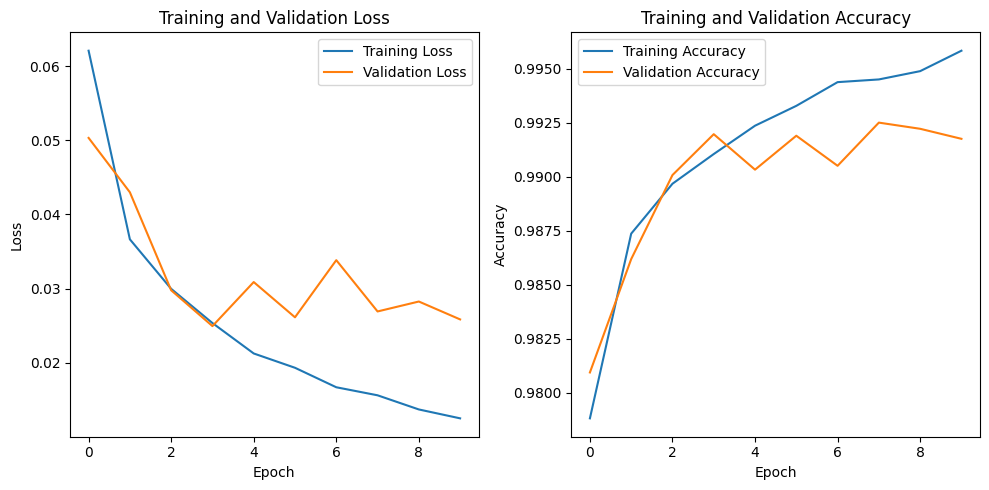

In [125]:
def plot_history(history):
    # Get the data from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

## 5. Model Evaluation

In [126]:
nn = ClassicNN(input_shape, num_categories=2, fname=checkpoint_filepath)
out = nn.model.evaluate(test_dataset)

875/875 [==============================] - 13s 14ms/step - loss: 0.0269 - accuracy: 0.9925


In [132]:
y_predicted = model.predict(X_test)

875/875 [==============================] - 14s 16ms/step


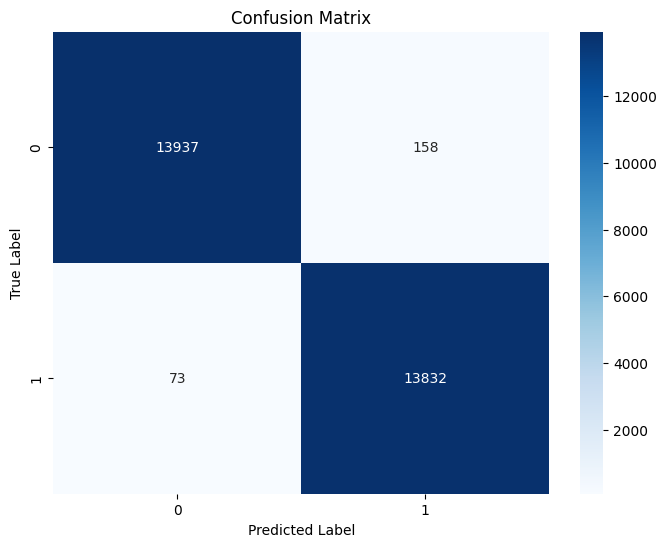

In [145]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test.astype(np.int8), np.argmax(y_predicted, axis=1))